In [38]:
#Import all the necessary files

import datetime
from geneformer import Classifier
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
from geneformer import TranscriptomeTokenizer, DataCollatorForCellClassification 


# Sex Classifier of cell nexus

In [39]:

current_date = datetime.datetime.now()
datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}{current_date.hour:02d}{current_date.minute:02d}{current_date.second:02d}"
datestamp_min = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"

output_prefix = "sex_classifier_cellnexus_v2_blood_cell_type_as_covariate"
output_dir = f"/hpcfs/users/a1841503/Geneformer/cellnexus/trained_classifiers/sex_classifier_v1_cellnexus/{datestamp}"
!mkdir $output_dir

In [ ]:
#Reading the anndata object
adata=sc.read_h5ad("/hpcfs/users/a1841503/Geneformer/cellnexus/data/combined_anndata.h5ad")
adata.obs.cell_type.describe()
adata.obs.sex.describe()
adata.obs.dataset_id.describe()

count                                   818287
unique                                      36
top       c7775e88-49bf-4ba2-a03b-93f00447c958
freq                                    100000
Name: dataset_id, dtype: object

Sex distribution:
sex
male       391115
female     337567
unknown     89605
Name: count, dtype: int64


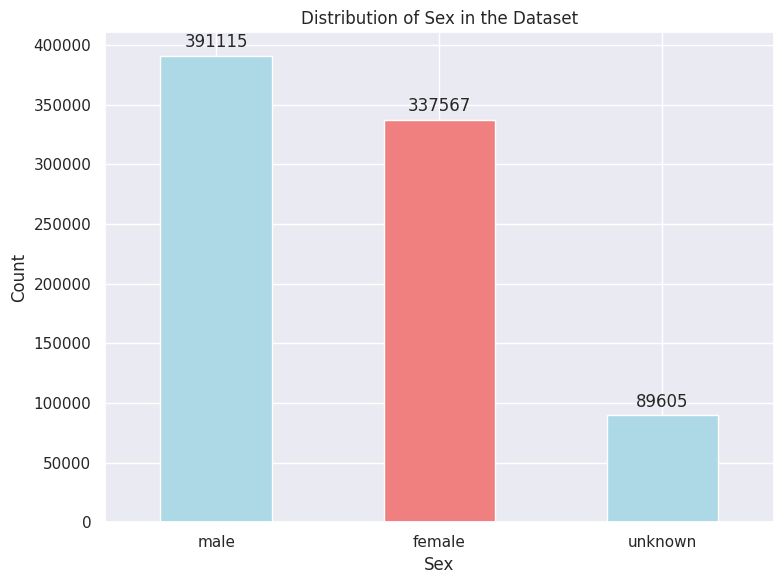

In [ ]:
# Get the sex distribution
sex_counts = adata.obs.sex.value_counts()
print("Sex distribution:")
print(sex_counts)

# Create a bar plot
fig, ax = plt.subplots(figsize=(8, 6))
sex_counts.plot(kind='bar', ax=ax, color=['lightblue', 'lightcoral'])
ax.set_title('Distribution of Sex in the Dataset')
ax.set_xlabel('Sex')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=0)

# Add count labels on top of bars
for i, v in enumerate(sex_counts.values):
    ax.text(i, v + max(sex_counts.values) * 0.01, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [42]:
#Removing the unknown from sex column
adata = adata[adata.obs['sex'] != 'unknown']
#adding the ensembl id and count to the anndata object
adata.var["ensembl_id"] = adata.var.index
adata.obs["n_counts"] = adata.X.sum(axis=1)
adata.obs["joinid"] = list(range(adata.n_obs))

#Saving the anndata object
adata.write_h5ad("/hpcfs/users/a1841503/Geneformer/cellnexus/data/sex/cell_type/anndata/combined_anndata_no_unknown.h5ad")

/mnt/tmp_local/lls_5496328/ipykernel_2953733/133117011.py:4: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["ensembl_id"] = adata.var.index


Sex distribution:
sex
male      391115
female    337567
Name: count, dtype: int64


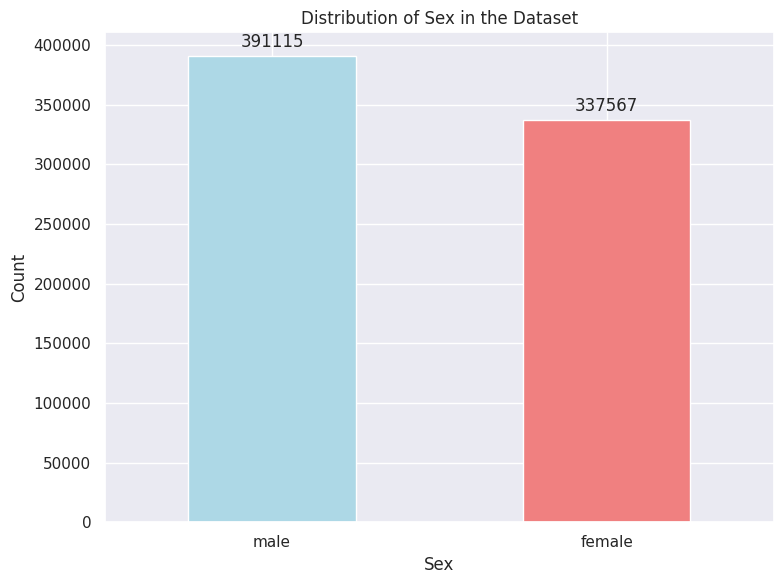

In [43]:
# Get the sex distribution
sex_counts = adata.obs.sex.value_counts()
print("Sex distribution:")
print(sex_counts)

# Bar plot
fig, ax = plt.subplots(figsize=(8, 6))
sex_counts.plot(kind='bar', ax=ax, color=['lightblue', 'lightcoral'])
ax.set_title('Distribution of Sex in the Dataset')
ax.set_xlabel('Sex')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=0)

# Add count labels on top of bars
for i, v in enumerate(sex_counts.values):
    ax.text(i, v + max(sex_counts.values) * 0.01, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:

# Geneformer directories for the 2048 model
gene_median_file_2048="/hpcfs/users/a1841503/Geneformer/geneformer/gene_dictionaries_30m/gene_median_dictionary_gc30M.pkl" 
token_dictionary_file_2048= "/hpcfs/users/a1841503/Geneformer/geneformer/gene_dictionaries_30m/token_dictionary_gc30M.pkl"
gene_mapping_file_2048= "/hpcfs/users/a1841503/Geneformer/geneformer/gene_dictionaries_30m/ensembl_mapping_dict_gc30M.pkl"

tk = TranscriptomeTokenizer(custom_attr_name_dict={"joinid": "joinid","sex": "sex","cell_type": "cell_type","dataset_id": "dataset_id"},
                            model_input_size = 2048,
                            special_token = False,
                            gene_median_file=gene_median_file_2048 ,
                            token_dictionary_file= token_dictionary_file_2048,
                            gene_mapping_file= gene_mapping_file_2048)

In [16]:
data_directory="/hpcfs/users/a1841503/Geneformer/cellnexus/data/sex/cell_type/anndata/"
token_dir="/hpcfs/users/a1841503/Geneformer/cellnexus/data/sex/cell_type/tokenized_combined_data/"
tk.tokenize_data(data_directory=data_directory,
                 output_directory=token_dir, 
                 output_prefix="sex_cell_type", 
                 file_format="h5ad")

Tokenizing /hpcfs/users/a1841503/Geneformer/cellnexus/data/sex/cell_type/anndata/combined_anndata_no_unknown.h5ad


/hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer/tokenizer.py:495: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer/tokenizer.py:498: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/hpcfs/users/a1841503/Geneformer/cellnexus/data/sex/cell_type/anndata/combined_anndata_no_unknown.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


In [45]:
filter_data_dict={"sex":["male","female"]}
training_args = {
    "num_train_epochs": 0.9,
    "learning_rate": 0.000804,
    "lr_scheduler_type": "polynomial",
    "warmup_steps": 1812,
    "weight_decay":0.258828,
    "per_device_train_batch_size": 12,
    "seed": 73,
}

# OF NOTE: model_version should match version of model to be used (V1 or V2) to use the correct token dictionary
cc = Classifier(classifier="cell",
                cell_state_dict = {"state_key": "sex", "states": "all"},
                filter_data=filter_data_dict,
                training_args=training_args,
                max_ncells=None,
                freeze_layers = 2,
                num_crossval_splits = 1,
                forward_batch_size=100,
                nproc=16)

In [24]:
datset_id_list=[
 '9dbab10c-118d-496b-966a-67f1763a6b7d',
 'bd65a70f-b274-4133-b9dd-0d1431b6af34',
 'cf83c98a-3791-4537-bbde-a719f6d73c13',
 '19e46756-9100-4e01-8b0e-23b557558a4c',
 'd7d7e89c-c93a-422d-8958-9b4a90b69558',
 'de2c780c-1747-40bd-9ccf-9588ec186cee',
 'ebc2e1ff-c8f9-466a-acf4-9d291afaf8b3',
 '01ad3cd7-3929-4654-84c0-6db05bd5fd59',
 '218acb0f-9f2f-4f76-b90b-15a4b7c7f629',
 '242c6e7f-9016-4048-af70-d631f5eea188',
 '2a498ace-872a-4935-984b-1afa70fd9886',
 '3c75a463-6a87-4132-83a8-c3002624394d',
 '1b9d8702-5af8-4142-85ed-020eb06ec4f6',
 '21d3e683-80a4-4d9b-bc89-ebb2df513dde',
 '30cd5311-6c09-46c9-94f1-71fe4b91813c',
 '3faad104-2ab8-4434-816d-474d8d2641db',
 '50eb1e23-b8d4-4f76-a184-44e5541fa05a',
 '53d208b0-2cfd-4366-9866-c3c6114081bc',
 '59b69042-47c2-47fd-ad03-d21beb99818f',
 '5af90777-6760-4003-9dba-8f945fec6fdf',
 '5bc42b88-bb76-4954-927b-8bb7369adc64',
 '5e717147-0f75-4de1-8bd2-6fda01b8d75f',
 '74cff64f-9da9-4b2a-9b3b-8a04a1598040',
 '79ef1959-a6b4-4cac-82ca-30feaec48df1',
 '84230ea4-998d-4aa8-8456-81dd54ce23af',
 '881fe679-c6e0-45a3-9427-c4e81be6921f',
 '8c42cfd0-0b0a-46d5-910c-fc833d83c45e',
 '8a554710-08bc-4005-87cd-da9675bdc2e7',
 'b0e547f0-462b-4f81-b31b-5b0a5d96f537',
 'c2a461b1-0c15-4047-9fcb-1f966fe55100',
 'c7775e88-49bf-4ba2-a03b-93f00447c958',
 'cab0bc48-744c-461b-aaf4-7bf2cb7af00d',
 'db59611b-42de-4035-93aa-1ed39f38b467',
 'ed5d841d-6346-47d4-ab2f-7119ad7e3a35',
 'eeacb0c1-2217-4cf6-b8ce-1f0fedf1b569',
 'fa8605cf-f27e-44af-ac2a-476bee4410d3']

In [47]:
# Manually balanced splits
# argument attr_to_split set to "dataset_id" and attr_to_balance set to ["sex"]
#Categories (11, object): ['01ad3cd7-3929-4654-84c0-6db05bd5fd59', '2a498ace-872a-4935-984b-1afa70fd9886', '3faad104-2ab8-4434-816d-474d8d2641db', '19e46756-9100-4e01-8b0e-23b557558a4c', ..., '59b69042-47c2-47fd-ad03-d21beb99818f', '218acb0f-9f2f-4f76-b90b-15a4b7c7f629', '242c6e7f-9016-4048-af70-d631f5eea188', 'b0e547f0-462b-4f81-b31b-5b0a5d96f537']
test_ids= ['21d3e683-80a4-4d9b-bc89-ebb2df513dde', '19e46756-9100-4e01-8b0e-23b557558a4c']
eval_ids= ['59b69042-47c2-47fd-ad03-d21beb99818f', 'b0e547f0-462b-4f81-b31b-5b0a5d96f537']
train_ids= ['242c6e7f-9016-4048-af70-d631f5eea188', '218acb0f-9f2f-4f76-b90b-15a4b7c7f629', '53d208b0-2cfd-4366-9866-c3c6114081bc','01ad3cd7-3929-4654-84c0-6db05bd5fd59','3faad104-2ab8-4434-816d-474d8d2641db','2a498ace-872a-4935-984b-1afa70fd9886','30cd5311-6c09-46c9-94f1-71fe4b91813c']
train_test_id_split_dict = {"attr_key": "dataset_id",
                            "train": train_ids+eval_ids,
                            "test": test_ids}
attr_to_balance =["sex"] 
input_data_file="/hpcfs/users/a1841503/Geneformer/cellnexus/data/sex/cell_type/tokenized_combined_data/sex_cell_type.dataset"
output_directory="/hpcfs/users/a1841503/Geneformer/cellnexus/data/sex/cell_type/prepared_tokenized_combined_data/"
split_id_dict={"attr_key": "dataset_id",
 "train":  ['242c6e7f-9016-4048-af70-d631f5eea188', '218acb0f-9f2f-4f76-b90b-15a4b7c7f629', '53d208b0-2cfd-4366-9866-c3c6114081bc','01ad3cd7-3929-4654-84c0-6db05bd5fd59','3faad104-2ab8-4434-816d-474d8d2641db','2a498ace-872a-4935-984b-1afa70fd9886','30cd5311-6c09-46c9-94f1-71fe4b91813c'],
 "test": ['21d3e683-80a4-4d9b-bc89-ebb2df513dde', '19e46756-9100-4e01-8b0e-23b557558a4c','59b69042-47c2-47fd-ad03-d21beb99818f', 'b0e547f0-462b-4f81-b31b-5b0a5d96f537']}
# Example input_data_file for 30M model: https://huggingface.co/datasets/ctheodoris/Genecorpus-30M/tree/main/example_input_files/cell_classification/disease_classification/human_dcm_hcm_nf.dataset
cc.prepare_data(input_data_file=input_data_file,
                output_directory=output_directory,
                output_prefix=output_prefix,
                split_id_dict=split_id_dict,
                attr_to_balance=attr_to_balance,)

In [ ]:
model_directory="/hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_foundation_models/models/30M_AGGsinglecell_6_emb256_SL2048_E2_B12_LR0.001_LSlinear_WU10000_Oadamw/checkpoint-75000"

train_valid_id_split_dict = {"attr_key": "dataset_id",
                            "train": train_ids,
                            "eval": eval_ids}
attr_to_balance=["cell_type","sex"]





# V1 model: https://huggingface.co/ctheodoris/Geneformer/blob/main/Geneformer-V1-10M/model.safetensors
all_metrics = cc.validate(model_directory=model_directory,  # OF NOTE: SET TO V1 MODEL ABOVE, PROVIDE V1 MODEL PATH HERE
                          prepared_input_data_file="/hpcfs/users/a1841503/Geneformer/cellnexus/trained_classifiers/sex_classifier_v1_cellnexus/250820181105/sex_classifier_cellnexus_v2_celltype_as_covariate_labeled_train.dataset",
                          id_class_dict_file="/hpcfs/users/a1841503/Geneformer/cellnexus/data/sex/cell_type/prepared_tokenized_combined_data/sex_classifier_cellnexus_v2_blood_cell_type_as_covariate_id_class_dict.pkl",
                          output_directory=output_dir,
                          output_prefix=output_prefix,
                          n_hyperopt_trials=10,
                          attr_to_balance=attr_to_balance,
                          predict_eval=True,
                          predict_trainer=False,
                          save_eval_output=True,
                          )
                          # to optimize hyperparameters, set n_hyperopt_trials=100 (or alternative desired # of trials)

mkdir: cannot create directory ‘/hpcfs/users/a1841503/Geneformer/cellnexus/trained_classifiers/sex_classifier_v1_cellnexus/250821000338/250821_geneformer_cellClassifier_sex_classifier_cellnexus_v2_celltype_as_covariate/’: File exists


  0%|          | 0/1 [00:00<?, ?it/s]

****** Validation split: 1/1 ******



2025-08-21 00:15:16,165	INFO worker.py:1841 -- Started a local Ray instance.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_foundation_models/models/30M_AGGsinglecell_6_emb256_SL2048_E2_B12_LR0.001_LSlinear_WU10000_Oadamw/checkpoint-75000 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to

== Status ==
Current time: 2025-08-21 00:15:19 (running for 00:00:00.16)
Using FIFO scheduling algorithm.
Logical resource usage: 0/72 CPUs, 0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5473703/ray/session_2025-08-21_00-15-02_295962_2612207/artifacts/2025-08-21_00-15-19/_objective_2025-08-21_00-15-19/driver_artifacts
Number of trials: 1/10 (1 PENDING)
+---------------------+----------+-------+-----------------+---------------------+--------------------+------------------------+--------+----------------+----------------+
| Trial name          | status   | loc   |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |   seed |   warmup_steps |   weight_decay |
|                     |          |       |                 |                     |                    |                ch_size |        |                |                |
|---------------------+----------+-------+-----------------+---------------------+------------------

(_objective pid=2638234) Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
(_objective pid=2638234) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_foundation_models/models/30M_AGGsinglecell_6_emb256_SL2048_E2_B12_LR0.001_LSlinear_WU10000_Oadamw/checkpoint-75000 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
(_objective pid=2638234) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/85166 [00:00<?, ?it/s]/hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, i

In [24]:
cc

In [50]:
cc = Classifier(classifier="cell",
                cell_state_dict = {"state_key": "sex", "states": "all"},
                forward_batch_size=50,
                nproc=16)

Hyperparameter tuning is highly recommended for optimal results. No training_args provided; using default hyperparameters.


In [51]:
all_metrics_test = cc.evaluate_saved_model(
        model_directory="/hpcfs/users/a1841503/Geneformer/cellnexus/trained_classifiers/sex_classifier_v1_cellnexus/250720190054/250720_geneformer_cellClassifier_sex_classifier_cellnexus/ksplit1/run-e670ee6b/checkpoint-85166",
        id_class_dict_file="/hpcfs/users/a1841503/Geneformer/cellnexus/data/sex/cell_type/prepared_tokenized_combined_data/sex_classifier_cellnexus_v2_blood_cell_type_as_covariate_id_class_dict.pkl",
        test_data_file="/hpcfs/users/a1841503/Geneformer/cellnexus/data/sex/cell_type/prepared_tokenized_combined_data/sex_classifier_cellnexus_v2_blood_cell_type_as_covariate_labeled_test.dataset",
        output_directory=output_dir,
        output_prefix=output_prefix,
    )

  0%|          | 0/4653 [00:00<?, ?it/s]

<Figure size 1000x1000 with 0 Axes>

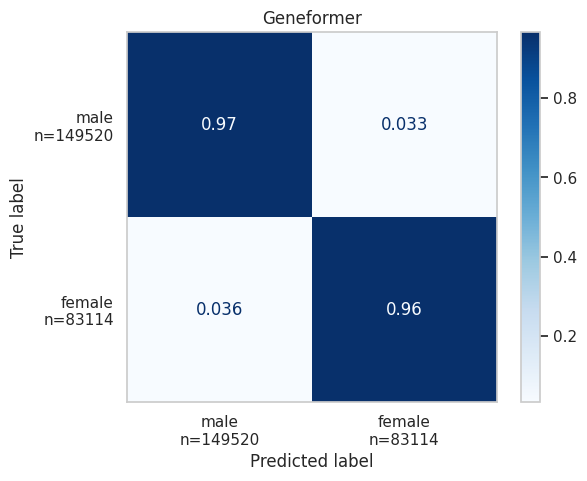

In [52]:
cc.plot_conf_mat(
        conf_mat_dict={"Geneformer": all_metrics_test["conf_matrix"]},
        output_directory=output_dir,
        output_prefix=output_prefix,
        custom_class_order=["male","female"],
)

<Figure size 1500x1500 with 0 Axes>

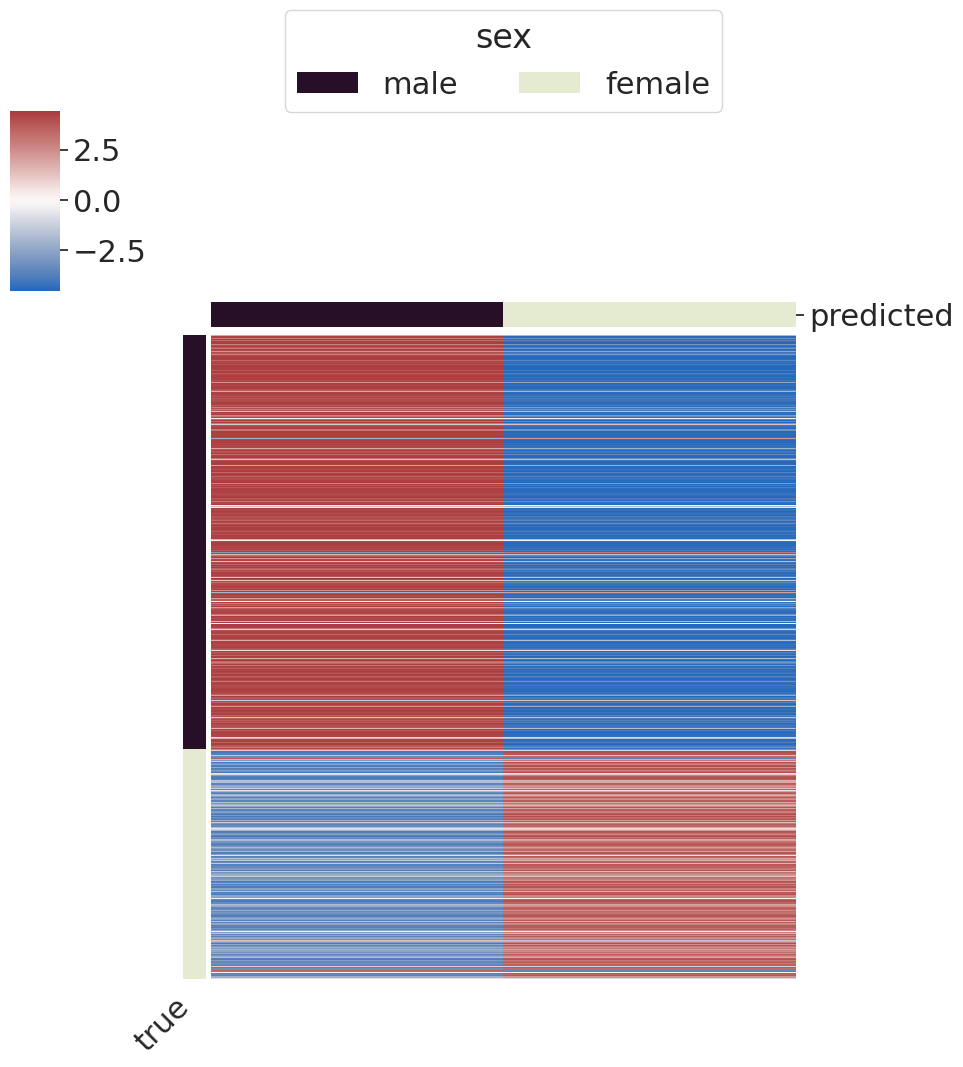

In [54]:
cc.plot_predictions(
    predictions_file=f"{output_dir}/{output_prefix}_pred_dict.pkl",
    id_class_dict_file="/hpcfs/users/a1841503/Geneformer/cellnexus/data/sex/cell_type/prepared_tokenized_combined_data/sex_classifier_cellnexus_v2_blood_cell_type_as_covariate_id_class_dict.pkl",
    title="sex",
    output_directory=output_dir,
    output_prefix=output_prefix,
    custom_class_order=["male","female"],
)


In [33]:
all_metrics_test

{'conf_matrix':          male  female
 male    63856    3080
 female   2169   58643,
 'macro_f1': 0.9588427589417423,
 'acc': 0.9589112941102796,
 'all_roc_metrics': {'mean_tpr': array([0.        , 0.80109189, 0.90125304, 0.93716701, 0.95750839,
         0.9686575 , 0.97572847, 0.98092482, 0.98449319, 0.98709136,
         0.98906466, 0.9909064 , 0.99246859, 0.99350457, 0.99427745,
         0.99491877, 0.99560942, 0.99621785, 0.99656318, 0.99704006,
         0.99741827, 0.99766493, 0.99797737, 0.9981747 , 0.99837203,
         0.99853647, 0.99870091, 0.9988818 , 0.99898046, 0.99916135,
         0.99927646, 0.99932579, 0.99947379, 0.99957245, 0.99967112,
         0.99973689, 0.99973689, 0.99975334, 0.99983556, 0.99986845,
         0.99986845, 0.99988489, 0.99991778, 0.99991778, 0.99991778,
         0.99991778, 0.99995067, 0.99995067, 0.99995067, 0.99995067,
         0.99995067, 0.99995067, 0.99995067, 0.99995067, 0.99995067,
         0.99995067, 0.99995067, 0.99995067, 0.99995067, 0.99995